In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import Model
import warnings

warnings.simplefilter('ignore', FutureWarning)

if __name__ == "__main__":
	t = time.time()
	featureList = ['EPS Growth', 'Volatility 180 D', 'Trailing EPS', 'Price to Cash Flow', 'EPS', 'Volume', 'Return on Assets', 'Price to Book', 'Dividend Yield', 'Total Debt to Total Equity', 'Return on Invested Capital', 'Return on Common Equity']
	train, validate, test = Model.splitData(300,3,12)
	sector = "Financials"
	randForest = Model.buildWithIndexesTripleClass(modelType = Model.randomForestClassifier, indexes = train, target= 'Rate of Return', features = featureList, featureLength = 12,\
									targetLength = 3, sector = sector, percentileTarget = 90, percentileAvoid = 10, verbose = True)
	print(time.time() - t, "seconds wait time")
	print("Labels: ")
	print(randForest.classes_)
	print("Importances: ")
	print(randForest.feature_importances_)

[-175  -76  -22 -220 -202 -100 -226  -88 -187 -232  -28 -196 -250 -211 -280
 -283 -205 -142 -235 -151 -160  -70  -40 -154 -238 -229  -73 -133 -181 -136
  -31 -112 -289 -169 -274 -253 -118 -262 -178 -121 -268 -259  -91 -163 -157
 -286 -247  -61 -223  -52 -199 -217 -214 -184  -16 -145 -148]
[-298 -244 -103 -130  -46 -301  -85 -265 -256 -271  -67  -94 -139 -190  -79
 -292 -277  -43  -55]
[ -82 -166  -25 -127 -295 -193  -58 -115 -172  -37 -208  -49 -124  -34 -241
  -64 -109  -97  -19 -106]
Finished data retrieval, starting model training.
Finished fitting.
140.98647618293762 seconds wait time
Labels: 
[0 1 2]
Importances: 
[ 0.09623473  0.12109446  0.08366386  0.09327425  0.08356077  0.0939179
  0.03971792  0.09238604  0.03967811  0.0802032   0.0885492   0.08771956]


In [2]:
precisions = {'seen':{}, 'above10':{}, 'above75':{}, 'above50':{}, 'above25':{}, 'above90':{}}
betterThan = {}
for prob in range(0,100,5):
	precisions['seen'][prob] = 0
	precisions['above10'][prob] = 0
	precisions['above75'][prob] = 0
	precisions['above50'][prob] = 0
	precisions['above25'][prob] = 0
	precisions['above90'][prob] = 0
for i in validate:
	addedStocks, probabilities = Model.predict_probabilities(randForest, startIndex = i, endIndex = i+11, features = featureList, sector = sector)
	actual = []
	for prob in range(0,100,5):
		betterThan[prob] = []
	for stock in addedStocks:
		actual.append(Model.rateOfReturn(Model.retrieveData(stock, 'Last Price', i+12, i+14, [])))
	for i in range(len(probabilities)):
		for prob in range(0,100,5):
			if probabilities[i][1] > prob / 100:
				betterThan[prob].append(1)
			else:
				betterThan[prob].append(0)
	for prob in range(0,100,5):
		if sum(betterThan[prob]) > 0:
			precisions['above10'][prob] = (Model.precision(Model.getPercentile(actual, 10),betterThan[prob]) * len(betterThan[prob]) + precisions['above10'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above75'][prob] = (Model.precision(Model.getPercentile(actual, 75),betterThan[prob]) * len(betterThan[prob]) + precisions['above75'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above50'][prob] = (Model.precision(Model.getPercentile(actual, 50), betterThan[prob]) * len(betterThan[prob]) + precisions['above50'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above25'][prob] = (Model.precision(Model.getPercentile(actual, 25), betterThan[prob]) * len(betterThan[prob]) + precisions['above25'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above90'][prob] = (Model.precision(Model.getPercentile(actual, 90), betterThan[prob]) * len(betterThan[prob]) + precisions['above90'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['seen'][prob] = precisions['seen'][prob] + len(betterThan[prob])
x = []
y90 = []
y75 = []
y50 = []
y25 = []
y10 = []
counts = []
for prob in range(0,100,5):
	print(str(prob) + " above 90th percentile: " + str(precisions['above90'][prob]))
	print(str(prob) + " above 75th percentile: " + str(precisions['above75'][prob]))
	print(str(prob) + " above 50th percentile: " + str(precisions['above50'][prob]))
	print(str(prob) + " above 25th percentile: " + str(precisions['above25'][prob]))
	print(str(prob) + " above 10th percentile: " + str(precisions['above10'][prob]))
	counts.append(sum(betterThan[prob]))
	if (precisions['above10'][prob]) > 0:
		y90.append(precisions['above90'][prob])
		y75.append(precisions['above75'][prob])
		y50.append(precisions['above50'][prob])
		y25.append(precisions['above25'][prob])
		y10.append(precisions['above10'][prob])
		x.append(prob)

0 above 90th percentile: 0.098984319751
0 above 75th percentile: 0.239591831036
0 above 50th percentile: 0.477560322234
0 above 25th percentile: 0.713900491404
0 above 10th percentile: 0.856361649118
5 above 90th percentile: 0.130008363766
5 above 75th percentile: 0.273191541966
5 above 50th percentile: 0.491534625125
5 above 25th percentile: 0.711398313437
5 above 10th percentile: 0.854106004322
10 above 90th percentile: 0.156927626838
10 above 75th percentile: 0.299884412095
10 above 50th percentile: 0.492827571634
10 above 25th percentile: 0.689724104461
10 above 10th percentile: 0.839374641968
15 above 90th percentile: 0.179036594739
15 above 75th percentile: 0.322515937047
15 above 50th percentile: 0.506460403157
15 above 25th percentile: 0.686039152172
15 above 10th percentile: 0.823102612607
20 above 90th percentile: 0.201288498036
20 above 75th percentile: 0.345966751841
20 above 50th percentile: 0.514865038993
20 above 25th percentile: 0.694504416085
20 above 10th percentile: 

Counts: 
[276, 129, 83, 63, 52, 43, 33, 27, 25, 19, 18, 13, 8, 7, 7, 5, 4, 0, 0, 0]


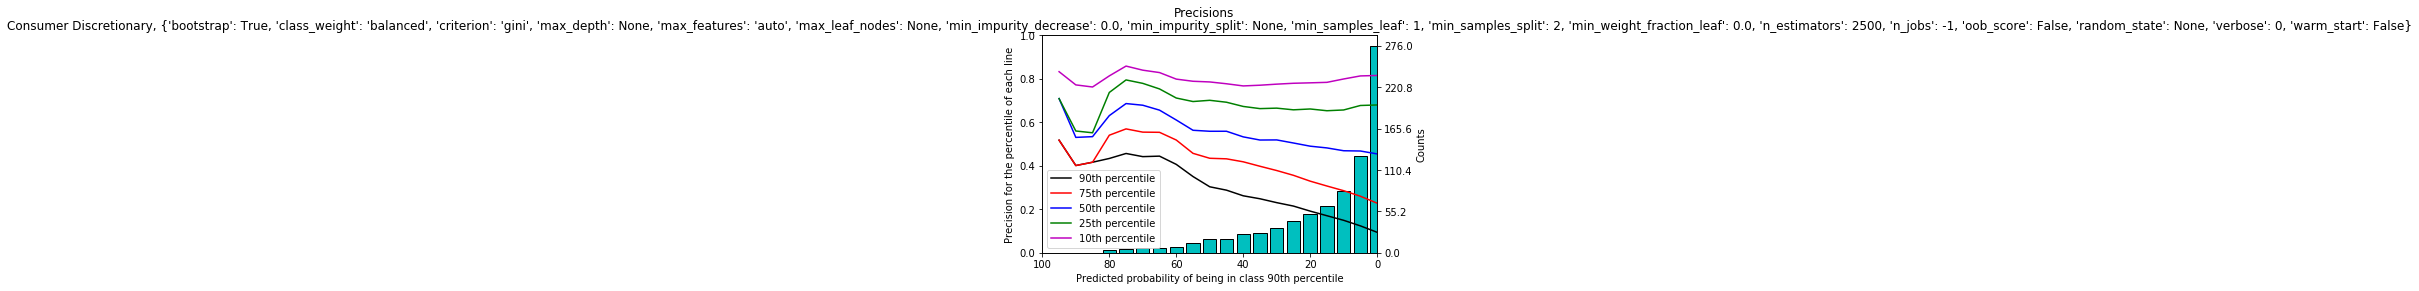

In [3]:
print("Counts: ")
print(counts)
fig = plt.figure()
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_xlim([0,100])
plt.suptitle("Precisions")
plt.title(sector + ", " + str(randForest.get_params()))
plt.xlabel('Predicted probability of being in class 90th percentile')
plt.ylabel('Precision for the percentile of each line')
axes.invert_xaxis()
bar = axes.twinx()
rects = bar.bar(x = list(range(0,100,5)), height = list(map(lambda x: x/max(counts),counts)), width = 4, color = 'c', linestyle = 'solid', edgecolor = 'k', zorder = -1)
bar.set_yticklabels(list(map(lambda x: x * max(counts) / 5, range(0,6,1))))
bar.set_ylabel('Counts', color = 'k')
plt.plot(x, y90, color = 'k', label = "90th percentile")
plt.plot(x, y75, color = 'r', label = "75th percentile")
plt.plot(x, y50, color = 'b', label = "50th percentile")
plt.plot(x, y25, color = 'g', label = "25th percentile")
plt.plot(x, y10, color = 'm', label = "10th percentile")
plt.legend()

In [4]:
fig.savefig(str(time.time()) + 'test.jpg', dpi=900)
plt.show()

Feature ranking:
1. Volatility 180 D (0.121094)
2. EPS Growth (0.096235)
3. Volume (0.093918)
4. Price to Cash Flow (0.093274)
5. Price to Book (0.092386)
6. Return on Invested Capital (0.088549)
7. Return on Common Equity (0.087720)
8. Trailing EPS (0.083664)
9. EPS (0.083561)
10. Total Debt to Total Equity (0.080203)
11. Return on Assets (0.039718)
12. Dividend Yield (0.039678)


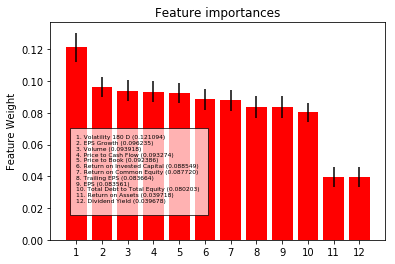

In [5]:
# adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = randForest.feature_importances_
std = np.std([est.feature_importances_ for est in randForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
textString = ''
for f in range(len(featureList)):
    print("%d. %s (%f)" % (f + 1, featureList[indices[f]], importances[indices[f]]))
    textString += "%d. %s (%f) \n" % (f + 1, featureList[indices[f]], importances[indices[f]])

# Plot the feature importances of the forest
fig2 = plt.figure()
plt.title("Feature importances")
plt.bar(range(len(featureList)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(featureList)), range(1,len(featureList)+1))
plt.xlim([-1, len(featureList)])
plt.ylabel('Feature Weight')
plt.text(0, 0.02, textString,
        bbox={'facecolor':'white', 'alpha':0.7, 'pad':6}, fontsize=6)
fig2.savefig(str(time.time()) + 'feature_importances.jpg', dpi=900)
plt.show()